In [1]:
from hamiltonians import LGTSchwingerModel
from qiskit.circuit.library import EvolvedOperatorAnsatz
import numpy as np
from qiskit import Aer, QuantumCircuit, QuantumRegister
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt

In [2]:
#VQE ansatz to generate input states
def make_VQE_ansatz(num_qubits, mass, num_layers_VQE):
    """
    input:
        - num_qubits: number of qubits
        - mass: value of mass
        - num_layers_VQE: number of layers
    output: Hamlitonian ansatz with an initial state |1010...> as QuantumCircuit
    note:
        - we fix a=1, g=1, theta0 = pi
        - need to import LGTSchwingerModel
    """
    #set all the coefficients for each term to physical values
    #usually they are fixed to some constants (e.g., 1)
    #here we fix a=1, g=1, theta0 = pi
    #if we also vary these parameters, we have to change the corresponding arguments
    H = LGTSchwingerModel(mass=mass, couple=1, num_sites=num_qubits, spacing=2, left_gauge=1/2)
    H_op = H.as_pauli_op()

    #we use init01, that means the following initial circuit
    init_circ = QuantumCircuit(num_qubits)
    for q in range(0, num_qubits, 2):
        init_circ.x(q)
    #Hamiltonian ansatz
    ansatz = EvolvedOperatorAnsatz
    varcirc = ansatz(operators=H_op, reps=num_layers_VQE, evolution=None, parameter_prefix='x',initial_state=init_circ)

    return varcirc

In [3]:
file_path='data/schwinger_N8a2/VQE_statevector/init_01/eps0.5_g1_vary_m_-2.0_2.0_0.05_SLSQP_EvolvedOperatorAnsatz_minRev_initPrevOpt_reps5'
params_VQE_list = np.load(file_path + "_VQEparams.npy").tolist()


In [4]:
elec_field_list_check = []
num_qubits = 8
num_layers_VQE = 5
# mass = 0.5
a = 2
g = 1
mass_min = -2.0
mass_max = 2.0
mass_step = 0.05
mass_list = np.arange(mass_min,mass_max+mass_step,mass_step)


In [5]:
qc=make_VQE_ansatz(num_qubits, 1, num_layers_VQE)

In [6]:
qc

In [18]:
estimator=Estimator()

ob_list=[]

#Symmetric ones:
# ob_list.append(SparsePauliOp.from_list([("X" * num_qubits, 1)]))
# ob_list.append(SparsePauliOp.from_list([("Y" * num_qubits, 1)]))
# ob_list.append(SparsePauliOp.from_list([("Z" * num_qubits, 1)]))

# ob_list.append(SparsePauliOp.from_list([("XX"+ "I"*(num_qubits-2), 1)]))
# ob_list.append(SparsePauliOp.from_list([("YY"+ "I"*(num_qubits-2), 1)]))
# ob_list.append(SparsePauliOp.from_list([("ZZ"+ "I"*(num_qubits-2), 1)]))
ob_list.append(SparsePauliOp.from_list([("I"*(num_qubits-2)+"ZZ", 1)]))

# ob_list.append(SparsePauliOp.from_list([("I"*(num_qubits-2)+"XX", 1)]))
# ob_list.append(SparsePauliOp.from_list([("I"*(num_qubits-2)+"YY", 1)]))
# ob_list.append(SparsePauliOp.from_list([("I"*(num_qubits-2)+"ZZ", 1)]))



In [19]:
estimator.run(circuits=[qc]*len(ob_list),
                        observables=ob_list,
                        parameter_values=[params_VQE_list[0]]*len(ob_list)).result().values

array([0.95356871])

In [20]:
estimator.run(circuits=[qc]*len(ob_list),
                        observables=ob_list,
                        parameter_values=[params_VQE_list[-1]]*len(ob_list)).result().values

array([-0.94907173])

In [21]:
num_data = mass_list.shape[0]
label_list = [0]*num_data
# mass_crit = 0.14189315334855837 #obtained from ED, Feb. 14, 2023
mass_crit = 0.143 #obtained from ED, June. 10, 2023

tomographic_data=[]
for index, mass in enumerate(mass_list):
    print(index)
    results=estimator.run(circuits=[qc]*len(ob_list),
                        observables=ob_list,
                        parameter_values=[params_VQE_list[index]]*len(ob_list)).result().values
    tomographic_data.append(results)
    if mass>mass_crit:
        label_list[index] = 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [22]:
tomographic_data=np.array(tomographic_data)
label_list=np.array(label_list)

In [23]:
X_train=[]
y_train=[]
mass_train=[]
X_test=[]
y_test=[]
mass_test=[]
for i in range(label_list.shape[0]):
    if i%5==0:
        X_test.append(tomographic_data[i])
        y_test.append(label_list[i])
        mass_test.append(mass_list[i])
        
    else:
        X_train.append(tomographic_data[i])
        y_train.append(label_list[i])
        mass_train.append(mass_list[i])
        


In [24]:
X_train=np.array(X_train)
y_train=np.array(y_train)

X_test=np.array(X_test)
y_test=np.array(y_test)


y_train[y_train==-1]=0
y_test[y_test==-1]=0

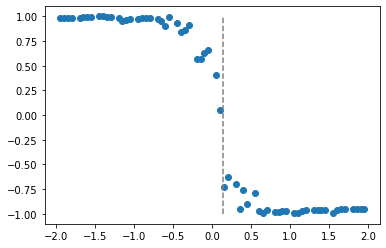

In [25]:
plt.scatter(mass_train,X_train.flatten(),label='train')
plt.vlines(x=mass_crit,ymin=-1,ymax=1, colors='gray', linestyle='dashed')

In [15]:
import tensorflow as tf


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
#    tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),  
])


In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.1 ,epochs=300)


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predict_train=model.predict(X_train).flatten()
predict_test=model.predict(X_test).flatten()

In [ ]:


plt.scatter(mass_train,predict_train,label='train')
plt.scatter(mass_test,predict_test,label='test')
plt.vlines(x=mass_crit,ymin=0,ymax=1, colors='gray', linestyle='dashed')

plt.xlabel('$g$',fontsize='15')
plt.ylabel('probability',fontsize='15')
plt.legend()